# MEMUAT DATA

In [8]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset
df = pd.read_csv("police.csv")

# Gabungkan tanggal dan waktu jadi satu kolom datetime
df['stop_datetime'] = pd.to_datetime(df['stop_date'] + ' ' + df['stop_time'])

# Menampilkan data

In [9]:
df.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,stop_datetime
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,2005-01-04 12:55:00
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,2005-01-23 23:15:00
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,2005-02-17 04:15:00
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,2005-02-20 17:15:00
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,2005-02-24 01:20:00


# Menampilkan Proporsi Gender Pelanggar Lalu Lintas

In [10]:
# Hitung proporsi
proporsi_gender = df['driver_gender'].value_counts(normalize=True).reset_index()
proporsi_gender.columns = ['driver_gender', 'proportion']
print(proporsi_gender)

  driver_gender  proportion
0             M     0.72527
1             F     0.27473


# Menampilkan potensi pelanggaran yang banyak dilakukan oleh kedua jenis kelamin

In [15]:
# 1. Buang baris kosong
df_clean = df.dropna(subset=['driver_gender', 'violation'])

# 2. Hitung jumlah pelanggaran per gender dan jenis pelanggaran
grouped = df_clean.groupby(['driver_gender', 'violation']).size().reset_index(name='jumlah')

# 3. Hitung total pelanggaran per gender
total_per_gender = grouped.groupby('driver_gender')['jumlah'].transform('sum')

# 4. Hitung proporsi
grouped['proportion'] = grouped['jumlah'] / total_per_gender

# 5. Urutkan hasil untuk kemudahan baca (optional)
grouped = grouped.sort_values(['driver_gender', 'proportion'], ascending=[True, False])

# 6. Tampilkan hasil
grouped[['driver_gender', 'violation', 'proportion']]

,driver_gender,violation,proportion
5,F,Speeding,0.658114
1,F,Moving violation,0.138218
0,F,Equipment,0.105199
3,F,Registration/plates,0.044418
2,F,Other,0.029738
4,F,Seat belt,0.024312
11,M,Speeding,0.522243
7,M,Moving violation,0.206144
6,M,Equipment,0.134158
8,M,Other,0.058985


# Membuat grafik yang menampilkan tingkat penangkapan yang dilakukan oleh pihak kepolisian

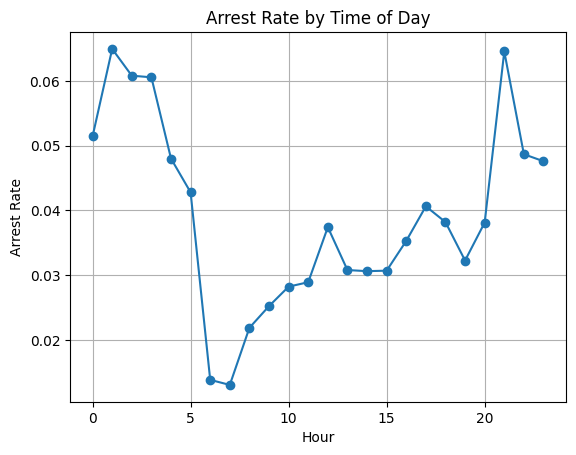

In [16]:
df['hour'] = df['stop_datetime'].dt.hour
arrest_rate_per_hour = df.groupby('hour')['is_arrested'].mean()

plt.plot(arrest_rate_per_hour, marker='o')
plt.title('Arrest Rate by Time of Day')
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.grid(True)
plt.show()

# Menampilkanlah data penangkapan karena keterkaitannya dengan penangkapan narkoba

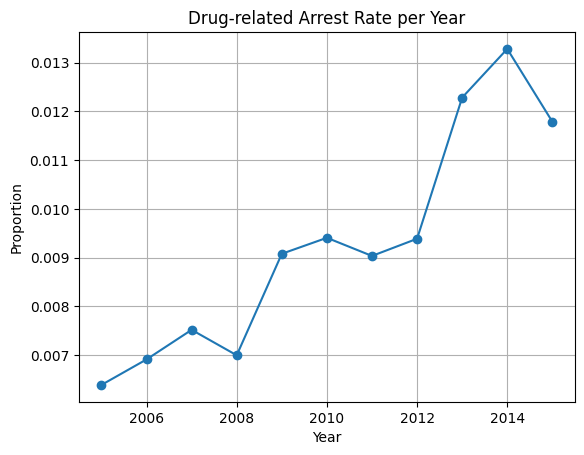

In [19]:
df['year'] = df['stop_datetime'].dt.year
narkoba_per_tahun = df.groupby('year')['drugs_related_stop'].mean()

plt.plot(narkoba_per_tahun, marker='o')
plt.title('Drug-related Arrest Rate per Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.grid(True)
plt.show()

# Menampilkanlah data yang menunjukan pemberhentian kendaraan dengan keterkaitannya dengan penangkapan narkoba

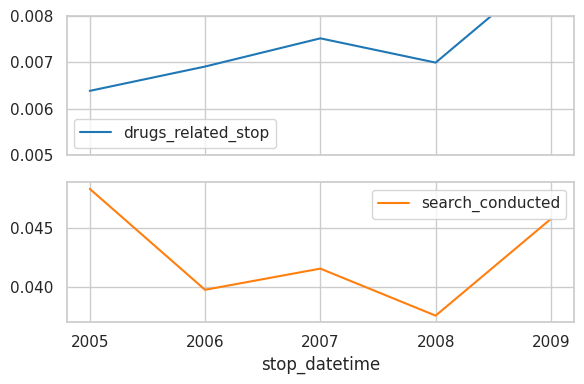

In [45]:
# Filter hanya tahun 2005–2009 dan salin untuk hindari warning
df_filtered = df[df['stop_datetime'].dt.year.between(2005, 2009)].copy()
df_filtered['year'] = df_filtered['stop_datetime'].dt.year

# Hitung rata-rata per tahun
summary = df_filtered.groupby('year').agg({
    'drugs_related_stop': 'mean',
    'search_conducted': 'mean'
}).reset_index()

# Plot grafik dua panel (identik dengan gambar)
fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

# Panel atas: drugs_related_stop
axes[0].plot(summary['year'], summary['drugs_related_stop'], label='drugs_related_stop', color='tab:blue')
axes[0].legend()
axes[0].set_ylim(0.005, 0.008)  # rentang sesuai permintaan

# Panel bawah: search_conducted
axes[1].plot(summary['year'], summary['search_conducted'], label='search_conducted', color='tab:orange')
axes[1].legend()

# X-axis: tampilkan tahun dengan jelas
axes[1].set_xticks(summary['year'])
axes[1].set_xticklabels(summary['year'])

# Label X
plt.xlabel('stop_datetime')
plt.tight_layout()
plt.show()

# Menampilkanlah grafik batang yang menunjukan pelanggaran yang berhubungan dengan distrik pengendara

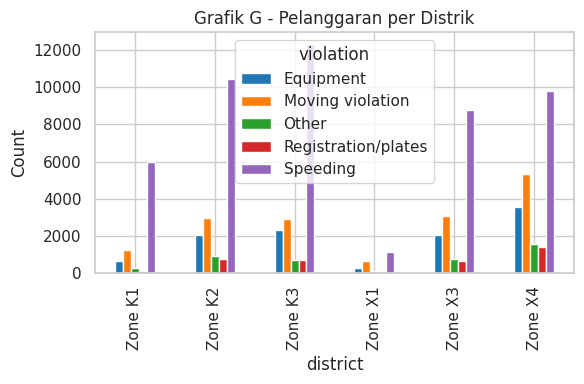

In [51]:
# Gunakan 5 kategori pelanggaran yang diinginkan
target_violations = ['Equipment', 'Moving violation', 'Other', 'Registration/plates', 'Speeding']
df_filtered = df[df['violation'].isin(target_violations)].dropna(subset=['violation', 'district'])

# Hitung jumlah pelanggaran per district dan violation
violation_counts = df_filtered.groupby(['district', 'violation']).size().unstack(fill_value=0)

# Pastikan urutan kolom sesuai warna tetap
violation_counts = violation_counts[target_violations]

# Warna
colors = {
    'Equipment': '#1f77b4',
    'Moving violation': '#ff7f0e',
    'Other': '#2ca02c',
    'Registration/plates': '#d62728',
    'Speeding': '#9467bd'
}

# Grafik G
fig, ax = plt.subplots(figsize=(6, 4))
violation_counts.plot(kind='bar', ax=ax, color=[colors[col] for col in violation_counts.columns])
plt.xlabel('district')
plt.ylabel('Count')
plt.legend(title='violation')
plt.title('Grafik G - Pelanggaran per Distrik')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Menampilkan grafik batang yang menampilkan hubungan distrik dari pengendara dengan pelanggaran yang dilakukan

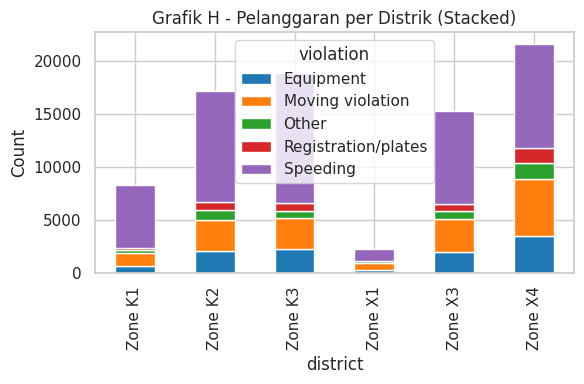

In [52]:
# Grafik H
fig, ax = plt.subplots(figsize=(6, 4))
violation_counts.plot(kind='bar', stacked=True, ax=ax, color=[colors[col] for col in violation_counts.columns])
plt.xlabel('district')
plt.ylabel('Count')
plt.legend(title='violation')
plt.title('Grafik H - Pelanggaran per Distrik (Stacked)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()